In [144]:
using Revise
using GraphPPL
using Rocket
using ReactiveMP
using Distributions
using Plots
using LinearAlgebra
using Random
import ProgressMeter

In [2]:
import ReactiveMP.messageout

In [139]:
include("helpers/data.jl")
include("helpers/form_constraint.jl")

In [4]:
function NN(y_,u_,θ)
    x = [y_;u_]'*θ
    1/(1+exp(-x))
end

NN (generic function with 1 method)

In [56]:
# Nonlinear MAX model definition
@model [default_factorisation=MeanField()] function nonlinear_max(n, dim, model_flow::FlowModel, params, h_prior, w_prior, y_prev, u)
    # initialize variables
    h       = randomvar(n)
    θ       = randomvar() where {form_constraint = FixedMarginalConstraint(MvNormalMeanPrecision(zeros(dim), ReactiveMP.huge*diageye(dim)))}  
    w       = randomvar() where {form_constraint = FixedMarginalConstraint(GammaShapeRate(1.0, 1.0))}
    y       = datavar(Float64, n)

    y_lat_1 = randomvar(n)
    y_lat_2 = randomvar(n)
    y_lat_3 = randomvar(n)
    
    del = nr_params(model_flow)
    params_flow = params[1:del]
    params_f = params[del+1:end]
    
    sigmoid_out = [NN(y_prev[i], u[i], params_f) for i in 1:n]

    # compile flow model
    Flow_meta  = FlowMeta(compile(model_flow, params_flow)) # default: FlowMeta(model, Linearization())
    h_0 ~ MvNormalMeanPrecision(h_prior[1], h_prior[2])

    θ   ~ MvNormalMeanPrecision(zeros(dim), ReactiveMP.huge*diageye(dim))
    w   ~ GammaShapeRate(w_prior[1], w_prior[2]) where {q=MeanField()}
    
    # specify transformed latent value
    
    AR_meta = ARMeta(Multivariate, dim, ARsafe())
    
    h_prev = h_0
    
    ar_nodes = Vector{FactorNode}(undef, n)
    y_nodes = Vector{FactorNode}(undef, n)
    for t in 1:n

        # specify latent state
        ar_nodes[t], h[t] ~ AR(h_prev, θ, w) where {q = q(y, x)q(γ)q(θ), meta = AR_meta}

        y_lat_1[t] ~ Flow(h[t]) where { meta = Flow_meta }
        y_lat_2[t] ~ dot(y_lat_1[t], ones(dim))
        y_lat_3[t] ~ y_lat_2[t] + sigmoid_out[t]

        y_nodes[t], y[t] ~ NormalMeanPrecision(y_lat_3[t], w)
        
        h_prev = h[t]
    end

    # return variables
    return h, θ, w, y_lat_1, y_lat_2, y_lat_3, y, y_nodes
end

nonlinear_max (generic function with 1 method)

In [57]:
function nonlinear_max_inference(observations,observations_prev, controls, model_flow::FlowModel, params; 
                                 h_prior=(zeros(dim), diageye(dim)), w_prior=(1.0, 1e3), dim=2, vmp_its = 10)
    # fetch number of samples
    n = length(observations)

    # define model
    model, (h, θ, w, y_lat_1, y_lat_2, y_lat_3, y, y_nodes) = nonlinear_max(n, dim, model_flow, params, h_prior, w_prior,
                                                                            observations_prev, controls,
                                                                            options = (limit_stack_depth = 500, ))
    
    h_post = getmarginals(h)
    
    h_buffer = Vector{Marginal}(undef, n)
    y_out_buffer = Vector{AbstractMessage}(undef, n)
    w_buffer = nothing
    
    h_sub = subscribe!(h_post, (x) -> copyto!(h_buffer, x))
    w_sub = subscribe!(getmarginal(w), (x) -> w_buffer = x)
    y_out_sub = subscribe!(collectLatest(messageout.(ReactiveMP.getinterface.(y_nodes, :out))), (x) -> copyto!(y_out_buffer, ReactiveMP.as_message.(x)))
    
    # initialize free energy
    fe_buffer = Vector()
    
    # subscribe
    fe_sub = subscribe!(score(BetheFreeEnergy(), model), (f) -> push!(fe_buffer, f))

    setmarginal!(w, GammaShapeRate(1.0, 1.0))
    setmarginal!(θ, MvNormalMeanPrecision(zeros(dim), ReactiveMP.huge*diageye(dim)))
    
    for _ in 1:vmp_its
        ReactiveMP.update!(y, observations)
    end
    
    # unsubscribe
    unsubscribe!(fe_sub)
    unsubscribe!(h_sub)
    unsubscribe!(w_sub)
    
    
    # return the marginal values
    return fe_buffer, h_buffer, w_buffer, y_out_buffer
    
end

nonlinear_max_inference (generic function with 1 method)

In [58]:
# specify flow model
dim = 2
model_flow = FlowModel(dim,
    (
        AdditiveCouplingLayer(PlanarFlow()), # defaults to AdditiveCouplingLayer(PlanarFlow(); permute=true)
        AdditiveCouplingLayer(PlanarFlow()),
        AdditiveCouplingLayer(PlanarFlow()),
        AdditiveCouplingLayer(PlanarFlow())
    )
);

In [140]:
Random.seed!(42)
n_samples = 1000
controls_ = 3 .* sin.(collect(1:n_samples+10))
order_y, order_u, order_e = 1, 1, 1
y_lat, y_obs, h_gen = generate_data(n_samples, narx, Dict(:order_y=>order_y, :order_u=>order_u, :order_e=>order_e),
                                                 Dict(:er_var=>1e0, :u=>controls_))

(Any[-0.5953342440194989, 0.7059652725844225, -0.6076235707193849, -0.7602218731430134, -0.19581345082843976, -0.16045544371521672, 0.6191693221092425, 0.28927342378407694, 0.4186075814438817, 0.6031980646077512  …  -0.7306813033781794, -0.3181674464664562, -0.05966879016253327, 0.6947196410571905, 0.11730796601524346, 0.3960100600572058, -0.7038194198095507, -0.7323367310575121, -0.5753935199579259, 0.523357061051279], [-0.1174398541442342, -0.8436558488726875, -0.012247581054527723, -1.0801696816059745, 0.8010013292968999, -0.18896526801233862, 0.4809745902713001, 0.6605943456187343, 0.8608893063952786, 1.7139437278157184  …  -0.3337741689196568, -1.5185301519822674, -0.05572253802852719, 0.4180231883970054, 2.7216025266431516, -0.03521463433855904, -0.19610943097613598, -1.3784095846103817, -0.8534490003333021, -0.6452582054031619], [-3.83690465086234, -0.24832160485318866, -0.7182128536389503, -0.47254611088658954, 1.5612232024399133, 0.0068481828161011315, 0.6414300339865168, 0.04

In [141]:
observations_prev = y_obs[1:end-1]
observations = y_obs[2:end];
controls = controls_[order_u:end];

In [142]:
train_size = 800
X_train, Y_train, U_train = observations_prev[1:train_size], observations[1:train_size], controls[1:train_size]
X_test, Y_test, U_test = observations_prev[train_size+1:end], observations[train_size+1:end], controls[train_size+1:end];

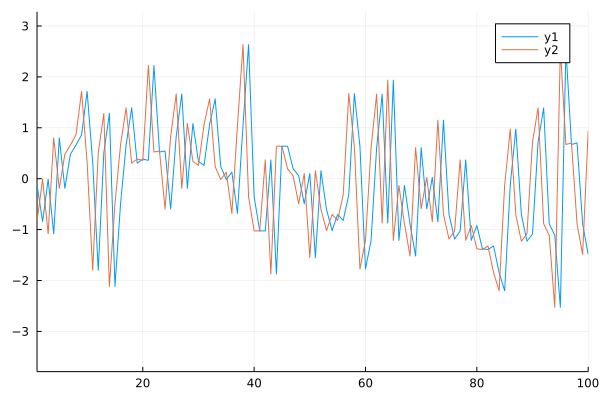

In [143]:
from, to = 1, 100
plot(X_train, xlims=(1, train_size))
plot!(Y_train, xlims=(from, to))

In [63]:
function FE(params)
    fe, h, w, y_out = nonlinear_max_inference(Y_train, X_train, U_train, model_flow, params, dim=2, vmp_its=50)
    return fe[end]
end;

In [64]:
param_len = nr_params(model_flow)

12

In [65]:
fe, h, w, y_out = nonlinear_max_inference(Y_train, X_train, U_train, model_flow, randn(param_len+2), dim=2, vmp_its=100);

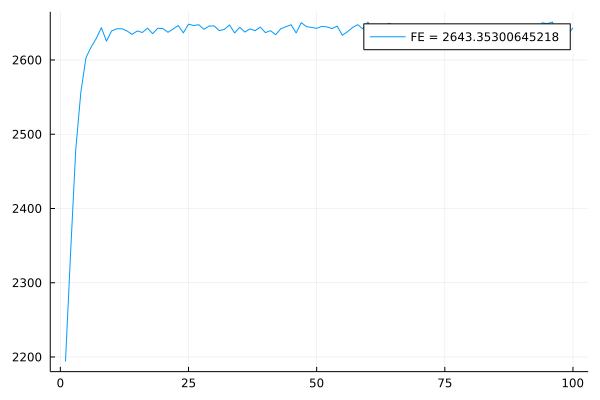

In [34]:
gr()
plot(fe, label="FE = $(fe[end])")

In [35]:
using Optim
res = optimize(FE, randn(nr_params(model_flow)+2), LBFGS(), Optim.Options(store_trace = true, show_trace = true), autodiff=:forward)

Iter     Function value   Gradient norm 
     0     2.591033e+03     1.466393e+03
 * time: 6.580352783203125e-5


     1     2.204588e+03     4.226212e+02
 * time: 133.59020400047302


     2     2.188875e+03     1.820599e+02
 * time: 154.60578298568726


     3     2.135934e+03     4.987600e+02
 * time: 199.54443502426147


     4     2.067664e+03     4.043665e+02
 * time: 246.46645498275757


     5     2.026226e+03     5.279750e+02
 * time: 292.1134419441223


     6     1.989306e+03     5.269397e+02
 * time: 325.12054681777954


     7     1.939248e+03     3.867759e+02
 * time: 347.52054381370544


     8     1.918930e+03     4.328451e+02
 * time: 370.3682029247284


     9     1.888592e+03     5.880814e+02
 * time: 403.66252398490906


    10     1.853646e+03     1.158372e+03
 * time: 436.58695697784424


    11     1.830848e+03     4.415558e+02
 * time: 459.0391309261322


    12     1.817999e+03     2.832675e+02
 * time: 492.9700629711151


    13     1.813081e+03     3.872723e+02
 * time: 515.3421638011932


    14     1.767097e+03     4.328519e+02
 * time: 547.6260738372803


    15     1.749764e+03     5.107661e+02
 * time: 569.4446959495544


    16     1.679623e+03     1.317602e+03
 * time: 603.4966340065002


    17     1.672730e+03     2.574363e+02
 * time: 636.4450747966766


    18     1.667477e+03     1.168998e+02
 * time: 658.4595918655396


    19     1.660641e+03     7.179754e+02
 * time: 714.5732309818268


    20     1.659605e+03     8.338150e+02
 * time: 736.2464818954468


    21     1.650146e+03     8.730239e+02
 * time: 769.3603649139404


    22     1.630340e+03     4.686611e+02
 * time: 803.2571699619293


    23     1.612274e+03     4.098171e+02
 * time: 825.9423289299011


    24     1.605543e+03     9.105468e+02
 * time: 849.4203100204468


    25     1.596143e+03     1.235368e+03
 * time: 897.8706319332123


    26     1.591008e+03     1.334648e+03
 * time: 924.0850079059601


    27     1.582844e+03     1.240567e+03
 * time: 949.225744009018


    28     1.568866e+03     1.475654e+03
 * time: 973.8997340202332


    29     1.566296e+03     1.141863e+03
 * time: 997.7214579582214


    30     1.558335e+03     2.570973e+02
 * time: 1035.5560789108276


    31     1.553925e+03     2.129243e+02
 * time: 1072.1447398662567


    32     1.547610e+03     1.962647e+02
 * time: 1105.6333668231964


    33     1.540630e+03     1.158781e+02
 * time: 1138.634524822235


    34     1.528476e+03     4.830900e+02
 * time: 1173.328775882721


    35     1.521211e+03     1.313918e+02
 * time: 1219.2261898517609


    36     1.513307e+03     4.142576e+02
 * time: 1264.7483298778534


    37     1.508339e+03     5.128915e+02
 * time: 1286.3323669433594


    38     1.496855e+03     7.006445e+02
 * time: 1309.2709648609161


    39     1.475872e+03     1.499888e+03
 * time: 1332.8026778697968


    40     1.469481e+03     6.487877e+02
 * time: 1354.7358968257904


    41     1.467355e+03     2.189527e+02
 * time: 1382.166533946991


    42     1.462782e+03     8.499902e+02
 * time: 1406.9639999866486


    43     1.457806e+03     9.195836e+02
 * time: 1441.2944300174713


    44     1.452090e+03     2.086474e+02
 * time: 1475.454346895218


    45     1.449863e+03     5.550626e+02
 * time: 1498.4222338199615


    46     1.448441e+03     8.476550e+02
 * time: 1533.849562883377


    47     1.446970e+03     1.560738e+02
 * time: 1567.3604879379272


    48     1.444589e+03     6.112213e+02
 * time: 1599.7493419647217


    49     1.441105e+03     1.150350e+03
 * time: 1621.3230628967285


    50     1.439577e+03     4.906822e+02
 * time: 1643.5085430145264


    51     1.438386e+03     7.248737e+01
 * time: 1665.42311501503


    52     1.437517e+03     4.960967e+02
 * time: 1687.0147168636322


    53     1.437209e+03     2.044480e+02
 * time: 1708.9097888469696


    54     1.436971e+03     2.566297e+02
 * time: 1742.8458278179169


    55     1.436852e+03     1.520184e+02
 * time: 1777.836707830429


    56     1.436659e+03     2.319211e+02
 * time: 1811.1998269557953


    57     1.436574e+03     1.029958e+02
 * time: 2384.1634438037872


    58     1.436571e+03     9.063822e+01
 * time: 2957.4800238609314


    59     1.436529e+03     1.362890e+02
 * time: 2992.0185120105743


    60     1.436511e+03     1.366268e+02
 * time: 3584.513450860977


    61     1.436502e+03     1.370292e+02
 * time: 4201.775146007538


    62     1.436461e+03     3.811744e+01
 * time: 4225.328398942947


    63     1.436346e+03     1.600890e+02
 * time: 4249.034430027008


    64     1.436208e+03     8.711933e+01
 * time: 4284.370366811752


    65     1.436090e+03     6.535448e+01
 * time: 4307.647282838821


    66     1.436082e+03     5.677977e+01
 * time: 4931.913254976273


    67     1.436054e+03     3.696106e+01
 * time: 5551.750664949417


    68     1.436046e+03     3.551782e+01
 * time: 6128.039183855057


    69     1.435989e+03     7.163625e+01
 * time: 6171.777403831482


    70     1.435982e+03     6.886983e+01
 * time: 6788.054296970367


    71     1.435982e+03     6.886983e+01
 * time: 7640.602156877518


 * Status: success

 * Candidate solution
    Final objective value:     1.435982e+03

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 0.00e+00 ≤ 0.0e+00
    |x - x'|/|x'|          = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 6.89e+01 ≰ 1.0e-08

 * Work counters
    Seconds run:   7641  (vs limit Inf)
    Iterations:    71
    f(x) calls:    672
    ∇f(x) calls:   672


In [66]:
inf_params = Optim.minimizer(res)
FE(inf_params)

2550.3890992439556

In [67]:
inf_params = Optim.minimizer(res)


fe, h, w = nonlinear_max_inference(Y_train, X_train, U_train, model_flow, inf_params, dim=2, vmp_its=100);

In [68]:
inv(mean(w))

1.0

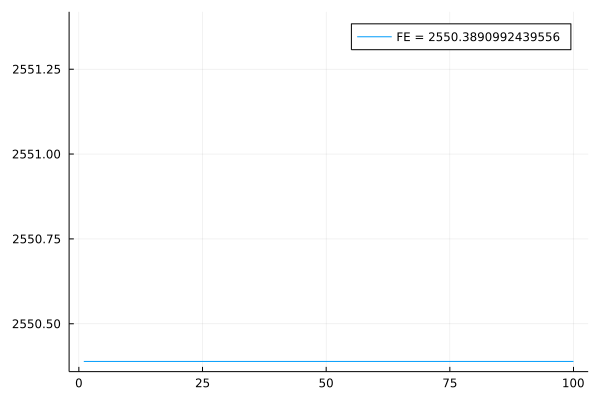

In [69]:
plot(fe, label="FE = $(fe[end])")

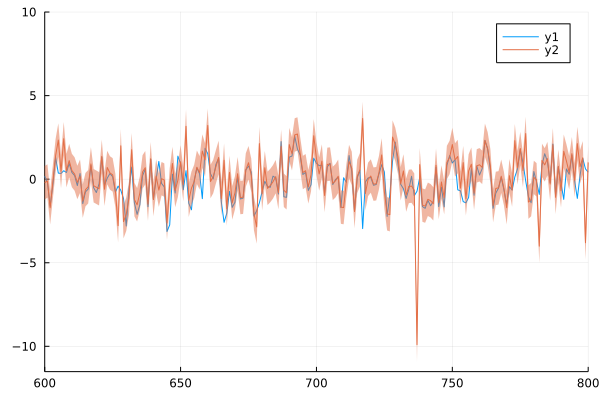

In [85]:
my, vy = mean.(y_out), cov.(y_out)
plot(Y_train, xlims=(600, 800))
plot!(my, ribbon=sqrt.(vy))

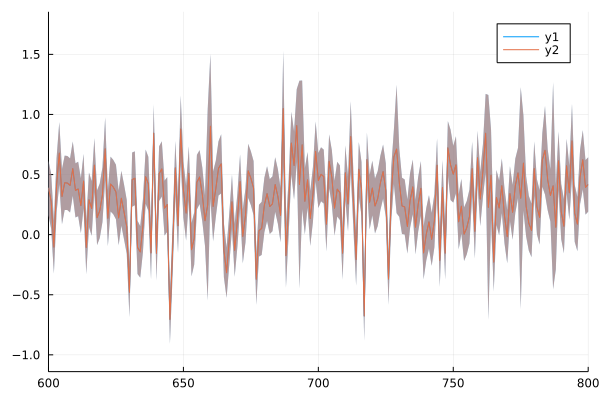

In [89]:
mh, vh = mean.(h), cov.(h)
plot(h_gen)
plot!(first.(mh), ribbon=sqrt.(first.(vh)), xlims=(600, 800))

In [72]:
# Nonlinear MAX model definition
@model [default_factorisation=MeanField()] function nonlinear_max_prediction(dim, model_flow::FlowModel, params, h_prior, w_prior, y_prev, u)
    # initialize variables
    
    y_pred       = datavar(Float64)
    
    del = nr_params(model_flow)
    params_flow = params[1:del]
    params_f = params[del+1:end]

    θ   = randomvar() where {form_constraint = FixedMarginalConstraint(MvNormalMeanPrecision(zeros(dim), ReactiveMP.huge*diageye(dim)))}  
    w   = randomvar() where {form_constraint = FixedMarginalConstraint(GammaShapeRate(1.0, 1.0))}

    sigmoid_pred = NN(y_prev, u, params_f)
    # @show sigmoid_pred

    # compile flow model
    Flow_meta  = FlowMeta(compile(model_flow, params_flow)) # default: FlowMeta(model, Linearization())
    h_0 ~ MvNormalMeanPrecision(h_prior[1], h_prior[2])
    θ   ~ MvNormalMeanPrecision(zeros(dim), ReactiveMP.huge*diageye(dim))
    w   ~ GammaShapeRate(w_prior[1], w_prior[2]) where {q=MeanField()}
    
    # specify transformed latent value
    
    AR_meta = ARMeta(Multivariate, dim, ARsafe())
    
    h_prev = h_0
    # specify observations
    
    ar_node, h ~ AR(h_prev, θ, w) where {q = q(y, x)q(γ)q(θ), meta = AR_meta}
    
    y_lat_1 ~ Flow(h) where { meta = Flow_meta }
    
    y_lat_2 ~ dot(y_lat_1, ones(dim))
    
    y_lat_3 ~ y_lat_2 + sigmoid_pred

    y_node, y ~ NormalMeanPrecision(y_lat_3, w)
    
    y_pred ~ NormalMeanPrecision(y, 1e-12)
    
    return h, θ, w, y_lat_1, y_lat_2, y_lat_3, y, y_node, y_pred
end

nonlinear_max_prediction (generic function with 2 methods)

In [126]:
function nonlinear_max_prediction(observation_prev::T, control::T, model_flow::FlowModel, params; 
                                  h_prior=(ones(dim), diageye(dim)), w_prior=(1.0, 1.0), dim=2, vmp_its = 50) where T<:Float64

    # define model
    model, (h, θ, w, y_lat_1, y_lat_2, y_lat_3, y, y_node, y_pred) = nonlinear_max_prediction(dim, model_flow, params, h_prior, w_prior,
                                                                                              observation_prev, control,
                                                                                              options = (limit_stack_depth = 500, ))
    
    h_buffer = nothing
    y_out_buffer = nothing
    w_buffer = nothing
    y_pred_buffer = nothing
    
    h_sub = subscribe!(getmarginal(h), (x) -> h_buffer = x)
    y_pred_sub = subscribe!(getmarginal(y), (x) -> y_pred_buffer = x)
    w_sub = subscribe!(getmarginal(w), (x) -> w_buffer = x)

    fe_buffer = Vector()
    
    # subscribe
    fe_sub = subscribe!(score(BetheFreeEnergy(), model), (f) -> push!(fe_buffer, f))
    
    setmarginal!(w, GammaShapeRate(1.0, 1.0))
    setmarginal!(θ, MvNormalMeanPrecision(zeros(dim), ReactiveMP.huge*diageye(dim)))
    setmarginal!(y, NormalMeanPrecision(0.0, 1.0))
    
    for _ in 1:vmp_its
        setmarginal!(θ, MvNormalMeanPrecision(zeros(dim), ReactiveMP.huge*diageye(dim)))
        ReactiveMP.update!(y_pred, 0.0)
    end
    
    # return the marginal values
    return fe_buffer, h_buffer, w_buffer, y_pred_buffer
    
end

nonlinear_max_prediction (generic function with 2 methods)

In [127]:
(mean(h[end]), precision(h[end]))
(shape(w), rate(w))
# inv(mean(w))

(1.0, 1.0)

In [134]:
predictions = []
h_pred = (mean(h[end]), precision(h[end]))
w_pred = (shape(w), rate(w))
rw = []
for i in 1:length(X_test)
    fe, h_pred_, w_pred_, y_pred = nonlinear_max_prediction(X_test[i], Float64(1e-4), model_flow, inf_params, h_prior=h_pred, w_prior=w_pred, dim=2, vmp_its=100)
    push!(predictions, y_pred)
    h_pred = (mean(h_pred_), precision(h_pred_))
    push!(rw, [mean(h_pred_)[1], cov(h_pred_)[1]])
end

In [135]:
mx, vx = mean.(predictions), cov.(predictions)

([-0.7514972517530487, -1.3287554989009045, -1.6299267007658869, -1.6008575634796094, -1.3301397860776727, -1.1127919124409336, -1.117299032041234, -1.533589634486485, -1.2817030320500307, -1.4482670686468408  …  -1.5648619407518667, -1.5456783236861076, -1.3514350716358783, -1.4453046377728014, -1.1431837998249554, -1.1229723488768821, -1.5781610749851518, -1.0328959892308949, -1.4075803368694313, -1.7333909063715227], [0.9578354399696681, 0.9567030801554726, 0.9564740874654766, 0.9564336373672406, 0.9564249031554471, 0.9564173683830642, 0.9564108404461691, 0.9564102296760586, 0.956418872067612, 0.9564152327749295  …  0.956424661333524, 0.9564223105240489, 0.9564212792737763, 0.9564171574942774, 0.9564184660630837, 0.9564122579400842, 0.9564106702848527, 0.9564196238412391, 0.9564100965276923, 0.9564162568910324])

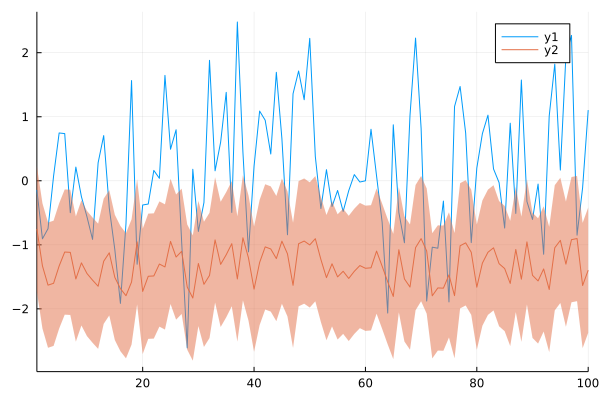

In [136]:
plot(Y_test[1:100])
plot!(mx, ribbon=sqrt.(vx), xlims=(1, 100))
# plot(mx, xlims=(1, 100))

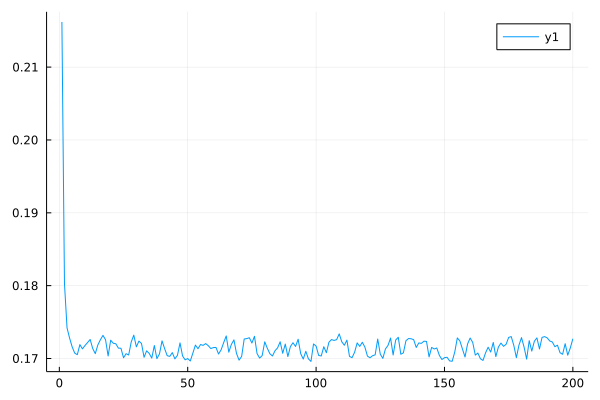

In [100]:
plot(first.(rw))